# Downloading using OpenID Connect (OIDC)

Requires a CDSE account

### Credentials
Username and password in a text file "cdse_credentials.txt" with the following structure:

```username=your_cdse_username
password=your_cdse_password```

In [15]:
def read_cdse_credentials(filepath="cdse_credentials.txt"):
    creds = {}
    with open(filepath, "r") as f:
        for line in f:
            key, value = line.strip().split("=", 1)
            creds[key.strip()] = value.strip()
    return creds["username"], creds["password"]

USERNAME, PASSWORD = read_cdse_credentials()

print("Credentials loaded (username only shown):", USERNAME)

Credentials loaded (username only shown): javieralonso.concha@esa.int


In [54]:
import requests

auth_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

data = {
    "client_id": "cdse-public",   # default public client
    "grant_type": "password",
    "username": USERNAME,
    "password": PASSWORD
}

response = requests.post(auth_url, data=data)
token = response.json()["access_token"]

print("Access token:", token[:60] + "...")


Access token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZK...


In [55]:
catalog_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products"
headers = {"Authorization": f"Bearer {token}"}

params = {
    "$filter": (
        "Collection/Name eq 'SENTINEL-2' "
        "and ContentDate/Start gt 2025-10-11T00:00:00.000Z "
        "and ContentDate/Start lt 2025-10-11T23:59:59.999Z "
        "and Attributes/OData.CSC.StringAttribute/any(a:a/Name eq 'productType' and a/Value eq 'S2MSI1C')"
    ),
    "$top": 5
}

resp = requests.get(catalog_url, headers=headers, params=params)
data = resp.json()["value"]

for p in data:
    print(p["Id"], p["Name"])


1af51d41-bcfb-4b2a-be19-c1b93533d148 S2B_MSIL1C_20251011T100029_N0511_R122_T31QGU_20251011T151516.SAFE
bafac8e8-d0a6-4a9c-9f57-63cb535f9359 S2B_MSIL1C_20251011T100029_N0511_R122_T31PGM_20251011T151516.SAFE
53436826-8518-4053-a45c-428402f2cbd0 S2B_MSIL1C_20251011T100029_N0511_R122_T31PFM_20251011T151516.SAFE
fa864229-7349-4ce3-810d-502bf46a15f7 S2B_MSIL1C_20251011T100029_N0511_R122_T31QGV_20251011T151516.SAFE
824e750e-8802-48a0-a832-9fa7ea5d60c0 S2B_MSIL1C_20251011T100029_N0511_R122_T32RNS_20251011T151516.SAFE


### Add a filter based on an ROI

In [56]:
# ROI4 Baltic (Lat1: 57, Lng1: 17, Lat2: 58, Lng2: 18)
Lat1 = 57
Lat2 = 58
Lng1 = 17
Lng2 = 18
bbox = f"POLYGON(({Lng1} {Lat1}, {Lng1} {Lat2}, {Lng2} {Lat2}, {Lng2} {Lat1}, {Lng1} {Lat1}))"
# bbox = "POLYGON((2.25 48.80, 2.25 48.90, 2.40 48.90, 2.40 48.80, 2.25 48.80))" #Paris(lng1 Lat1, Lng1 Lat2, Lng2 Lat2, Lng2 Lat1, Lng1 Lat1)


params["$filter"] += f" and OData.CSC.Intersects(area=geography'SRID=4326;{bbox}')"

resp = requests.get(catalog_url, headers=headers, params=params)
data = resp.json()["value"]

for p in data:
    print(p["Id"], p["Name"])

7b8bb2e4-5769-4f0c-ae44-4e09a4f4de99 S2A_MSIL1C_20251011T100951_N0511_R022_T34VCK_20251011T102927.SAFE
5eef0896-f056-42ee-924f-e2cfded0c2cb S2B_MSIL1C_20251011T100029_N0511_R122_T33VXD_20251011T133539.SAFE
29dc241d-bdc4-44c3-b0b8-2585c982a865 S2A_MSIL1C_20251011T100951_N0511_R022_T33VXD_20251011T102927.SAFE
7dd1b677-a046-48da-b75b-8e30e5609531 S2B_MSIL1C_20251011T100029_N0511_R122_T33VXE_20251011T133539.SAFE
d8f4fa18-37a7-4a96-baee-5263adba6eb1 S2A_MSIL1C_20251011T100951_N0511_R022_T34VCJ_20251011T102927.SAFE


### Downloading the data

In [60]:
import os
# create ./products if it does not exist
dir_path = "./products/"
if not os.path.isdir(dir_path):
    os.makedirs(dir_path)
    print("Directory products created successfully!")
else:
    print("Directory products already exists!")
    
img_idx = 3
product_id = data[img_idx]["Id"]

filename = f"{data[img_idx]['Name']}"
download_url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({product_id})/$value"



with requests.get(download_url, headers=headers, stream=True) as r:
    r.raise_for_status()
    with open(f"./products/{filename}.zip", "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)


print("Download complete:", filename + ".zip")


Download complete: S2B_MSIL1C_20251011T100029_N0511_R122_T33VXE_20251011T133539.SAFE.zip


### Unzipping the SAFE file

In [61]:
import zipfile
import os

zip_path = f"./products/{filename}.zip"
extract_folder = "./products/"

# Create the output folder if it doesn’t exist
os.makedirs(extract_folder, exist_ok=True)

# Extract all files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

safe_path = f"{extract_folder}{filename}/"    
print("Unzipped to:", safe_path)

Unzipped to: ./products/S2B_MSIL1C_20251011T100029_N0511_R122_T33VXE_20251011T133539.SAFE/


### Plotting

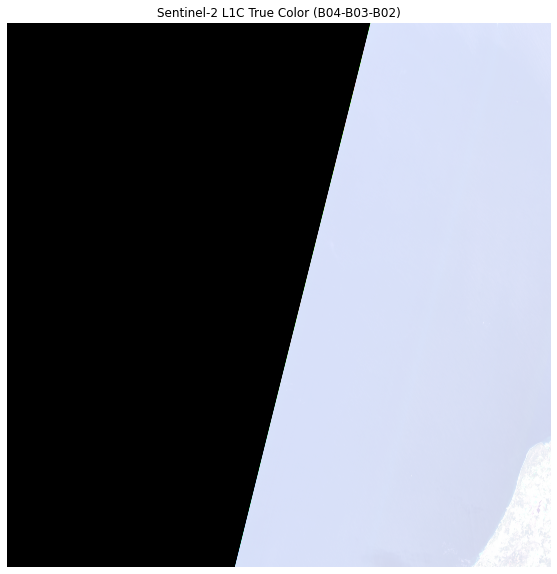

In [63]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt




# Locate the GRANULE folder and the 10m IMG_DATA subfolder
granule_dir = os.path.join(safe_path, "GRANULE")
granule_subdir = [d for d in os.listdir(granule_dir) if os.path.isdir(os.path.join(granule_dir, d))][0]
img_data_10m_dir = os.path.join(granule_dir, granule_subdir, "IMG_DATA")

# Some products store JP2 files under IMG_DATA/R10m
if os.path.exists(os.path.join(img_data_10m_dir, "R10m")):
    img_data_10m_dir = os.path.join(img_data_10m_dir, "R10m")

# Locate band files (B02=Blue, B03=Green, B04=Red)
band_files = {}
for band in ["B02", "B03", "B04"]:
    for f in os.listdir(img_data_10m_dir):
        if f.endswith(".jp2") and band in f:
            band_files[band] = os.path.join(img_data_10m_dir, f)

# Read bands using rasterio
bands = {}
for b, path in band_files.items():
    with rasterio.open(path) as src:
        bands[b] = src.read(1).astype(np.float32)

# Normalize and stack RGB
def normalize(array):
    array = np.clip(array, 0, np.percentile(array, 99))
    return (array - array.min()) / (array.max() - array.min())

rgb = np.dstack([
    normalize(bands["B04"]),  # Red
    normalize(bands["B03"]),  # Green
    normalize(bands["B02"])   # Blue
])

# Display RGB composite
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("Sentinel-2 L1C True Color (B04-B03-B02)")
plt.axis("off")
plt.show()